# Optimización de carteras para retiro



## Plan de trabajo

1. Se descargaran datos de los últimos dos años de una serie de ETFs que podrían tener poca superposición tanto por la naturaleza de sus activos subyacentes (bonos, acciones, metales preciosos) como por sus sectores (energia, tecnologícas, financieras) y sus regiones (USA, Europa, Emerging Markets)

2. Con esta información y el uso de la libreria PyPortfolio Opt y funciones adicionales se obtendrán los pesos relativos de esta lista de ETF's para cada estrategia. Quisieramos poder implementar portfolios con los algoritmos de HRP, MPT, como con estrategias clásicas como el 60-40. De esta forma daríamos respuesta a la pregunta 1

3. Una vez listados los portfolios, realizaremos 100 simulaciones de Montecarlo para cada portafolio del punto 2.  Se buscará tener algún insight respecto de si hay algún portfolio que sea más 'robusto' que otro en cuanto a su parecido a los datos reales (16.8 Advances in Financial ML - Lopez de Prado)

4. Por último se harán corridas considerando solo los portafolios de Max Sharpe y de Global Minimun Variance. Se realizará una estrategia 'fixed', en la que la % de MSR y GMV se mantienen constantes a lo largo del tiempo, y una estrategia 'switch', en la que en un determinado momento a determinar se cambia de 60% MSR a 40%MSR

### Instalaciones de paquetes e importado de módulos

In [ ]:
!pip install &> /dev/null PyPortfolioOpt
!pip install &> /dev/null yfinance
!pip install &> /dev/null ffn

In [ ]:
%matplotlib inline

from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting , HRPOpt, black_litterman, objective_functions, BlackLittermanModel, DiscreteAllocation
import yfinance as yf
import os
import ffn
from cvxopt import blas, solvers
import cvxopt as opt
from google.colab import drive
from sklearn.neighbors import KernelDensity
from scipy.linalg import eigh, cholesky
from scipy.stats import norm

from pylab import plot, show, axis, subplot, xlabel, ylabel, grid


plt.rcParams['figure.figsize'] = (14, 14)

### Descarga de información y limpieza

In [ ]:
# Correr celda solo si no hay datos
# Guardo en .csv series de precios extensa de varios activos para luego poder trabajar dividiendo en in-sample y out of sample
# Listado tentativo de ETF's para arrancar a modelar. Puede haber varios activos que no tengan sentido y limpiemos a posteriori
drive.mount('/content/drive')

#Importante: setear dirección de Drive del que esté ejecutando esta notebook
os.chdir('/content/drive/MyDrive/10. MiM/8. Financial Analytics/TP')

#Definimos variables en mayúsculas que se van a pasar a la API de yfinance. Todo lo demás en minúsculas
RISKY_ASSETS = ['AAPL', 'SPY', 'EEM','GLD','FXI','XLF','EWZ','ARKK','XLE','TLT','XLP','XLI','FEZ','HYG']

#Fechas arbitrarias de comienzo y fin de la muestra a descargar
START_DATE = '2015-01-01'
END_DATE = '2022-12-31'

#n_assets va a ser útil a la hora de iterar por la lista de activos
n_assets = len(RISKY_ASSETS)

# Serie de tiempo con toda la información de precios de cierre ajustada por split y dividendos
# Es un dataframe de 2014 filas x 14 columnas
prices_df = yf.download(RISKY_ASSETS, start=START_DATE,
                        end=END_DATE)['Adj Close']

print(f'Listado de activos considerados {prices_df.columns}')

#Guardo localmente el .csv con la información descargada
prices_df.to_csv('data.csv')

Mounted at /content/drive
[*********************100%***********************]  14 of 14 completed
Listado de activos considerados Index(['AAPL', 'ARKK', 'EEM', 'EWZ', 'FEZ', 'FXI', 'GLD', 'HYG', 'SPY', 'TLT',
       'XLE', 'XLF', 'XLI', 'XLP'],
      dtype='object')


## Análisis Exploratorio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Observaciones de la muestra de train: 501
Observaciones de la muestra de test: 1514


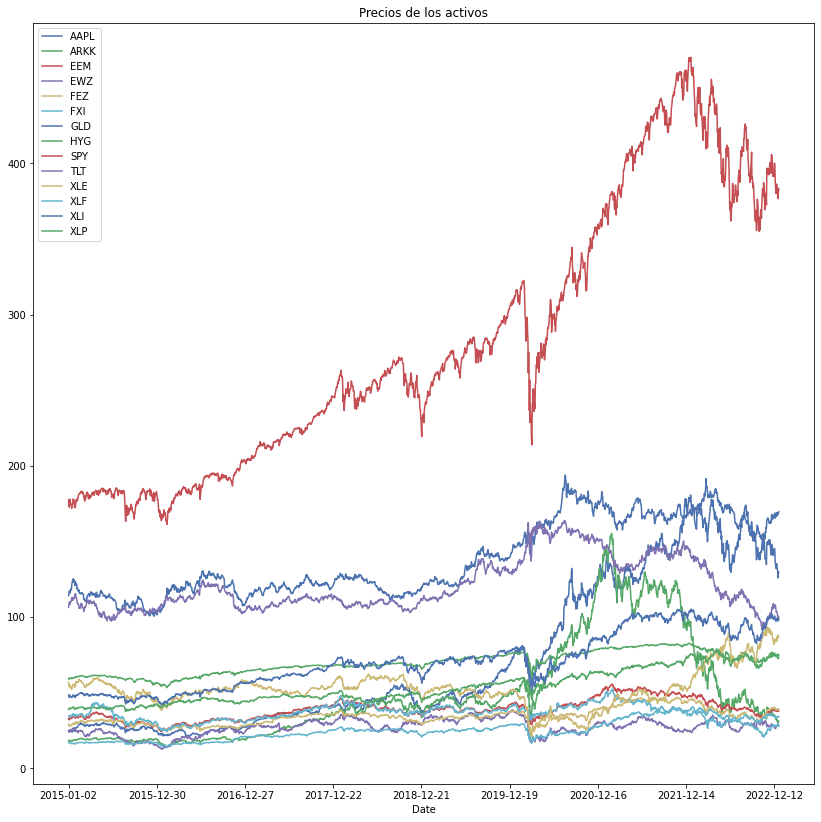

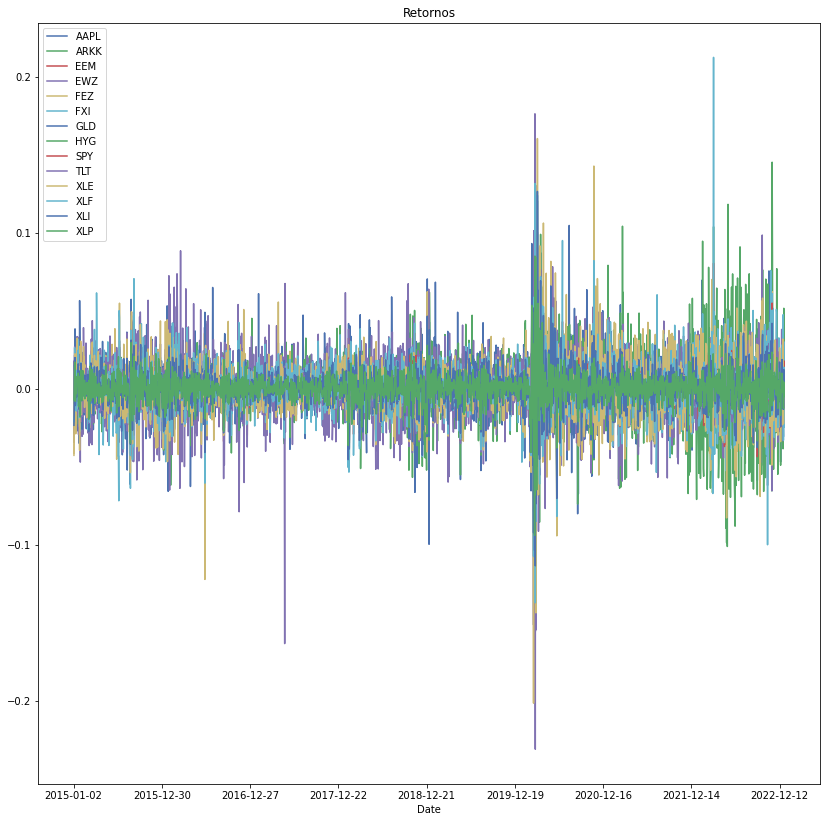

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 14)

# Descriptivo: armo algunos gráficos de precios y de retornos para explorar rapidamente
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/10. MiM/8. Financial Analytics/TP')

data = pd.read_csv('data.csv')
data = data.set_index('Date')

data.plot(title='Precios de los activos')
returns = data.to_returns()
returns.plot(title = 'Retornos')

#Separo la muestra de 514 filas en in-sample (primeras 200 observaciones) y out-of-sample (resto de observaciones)
#Buscamos evitar
data_past = data.iloc[:501,:]
returns_past = data_past.to_returns()
past_length = data_past.shape[0]
data_fwd = data.iloc[500:,:]
returns_fwd = data_fwd.to_returns()
fwd_length = data_fwd.shape[0]
print(f'Observaciones de la muestra de train: {past_length}')
print(f'Observaciones de la muestra de test: {fwd_length}')

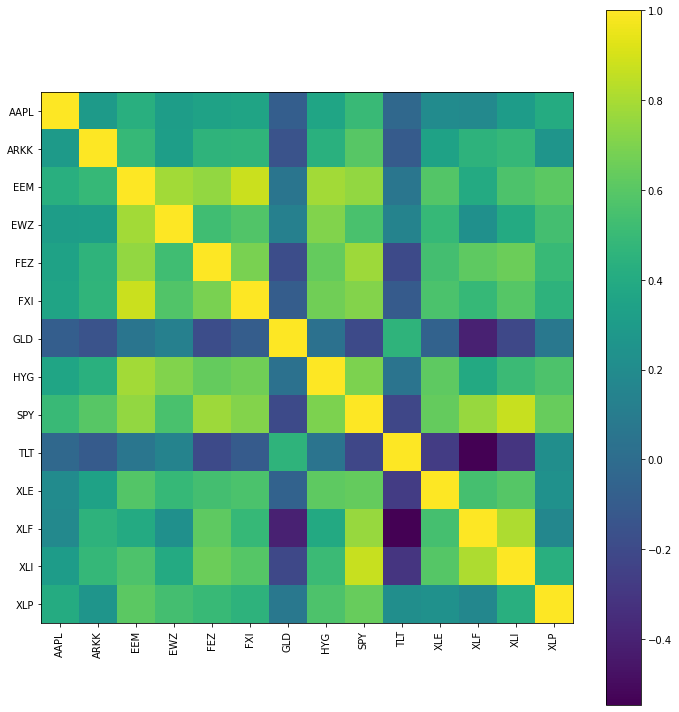

In [ ]:
# Matriz de covarianzas: usamos el cálculo de la matriz de covarianza exponencial del paquete pyportfolioopt para darle más peso a las observaciones recientes
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
exp_cov = risk_models.exp_cov(data_past)
cov_matrix_past = risk_models.exp_cov(data_past)
plotting.plot_covariance(exp_cov, plot_correlation=True)
plt.show()

## Ejercicio 1: Construcción de portafolios

In [ ]:
# Inicializamos un list of dicts para ir almacenando los portfolios que construiremos:

list_of_portfolios = []

### HRP

La estrategia de inversión HRP (Hierarchical Risk Parity) es una estrategia que busca asignar los pesos de los activos en una cartera de tal manera que se minimice el riesgo global de la cartera.

La estrategia HRP utiliza una técnica de optimización que utiliza una matriz de correlación de los activos para agruparlos en clústeres. Estos clústeres son utilizados para calcular los pesos de los activos en la cartera, asignando mayor peso a los clústeres con menor riesgo y menor peso a los clústeres con mayor riesgo.

La idea detrás de la estrategia HRP es diversificar el riesgo de la cartera de manera efectiva, y no solo a través de la diversificación de activos individuales, sino también a través de la diversificación de la clusterización jerárquica.


OrderedDict([('AAPL', 0.02575), ('ARKK', 0.042), ('EEM', 0.05092), ('EWZ', 0.0077), ('FEZ', 0.02335), ('FXI', 0.03311), ('GLD', 0.14075), ('HYG', 0.2829), ('SPY', 0.04961), ('TLT', 0.15779), ('XLE', 0.01786), ('XLF', 0.05908), ('XLI', 0.04271), ('XLP', 0.06647)])
Expected annual return: 3.2%
Annual volatility: 7.9%
Sharpe Ratio: 0.15


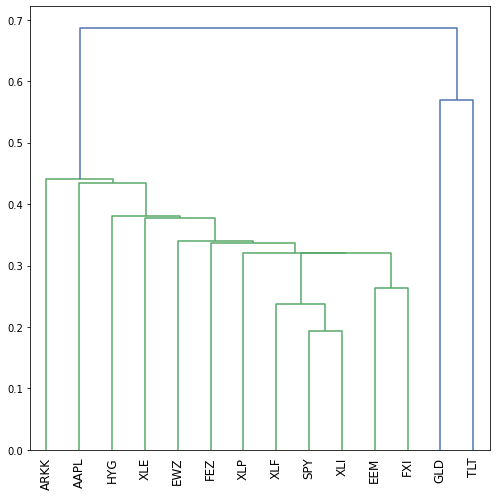

<AxesSubplot:ylabel='None'>

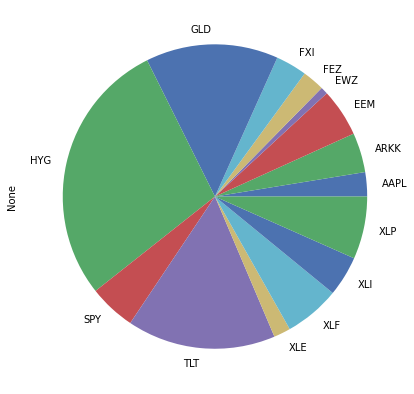

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 7)
# Se optimiza el portafolio y se imprimen los resultados
hrp = HRPOpt(returns_past)
hrp.optimize()
hrp_weights = hrp.clean_weights()
print(hrp_weights)

#Agrego los weights de HRP al diccionario de portfolios
list_of_portfolios = {'HRP': dict(hrp_weights)}

hrp.portfolio_performance(verbose=True);
plotting.plot_dendrogram(hrp)
plt.show()
pd.Series(hrp_weights).plot.pie()

Como presentación de los resultados primero podemos observar los pesos que el modelo le asignó a cada uno de los 14 activos de la cartera, es decir, el porcentaje del valor total de la cartera que se asigna a cada activo

En segundo lugar podemos analizar el rendimiento esperado anual, que en este caso es del 3.1%, y la volatilidad anual, que es del 7.9%. La volatilidad indica la medida de la variación en los rendimientos de la cartera, y puede ser utilizada como una medida del riesgo.

Por último, el Sharpe Ratio es una medida de la rentabilidad ajustada al riesgo y se calcula dividiendo el rendimiento anual por la volatilidad anual. En este caso, el Sharpe Ratio es de 0,40, lo que significa que por cada unidad de riesgo asumida, suponiendo una free-risk rate de 2%, la cartera genera 0,14 unidades de rendimiento adicional.

### Max Sharpe Ratio

#### Optimización Simple

El modelo de Max Sharpe Ratio es un modelo de optimización que busca encontrar la combinación óptima de activos que maximiza la relación entre el rendimiento esperado y la volatilidad de la cartera. En otras palabras, busca maximizar el índice de Sharpe –medida de la rentabilidad ajustada al riesgo de una inversión–. Cuanto mayor sea el índice de Sharpe, mejor será la relación entre el rendimiento y el riesgo de una cartera de inversión. Este índice es una medida de la rentabilidad que se obtiene por cada unidad de riesgo asumido.
En el desarrollo de este modelo fuimos iterando sobre el proceso de construcción de portafolio con el fin de encontrar un modelo que si bien cumpliera con la maximización del Sharpe Ratio, también lograra verificar otros criterios exigidos.

En primer lugar llevamos a cabo un modelo de maximización del Sharpe Ratio simple.

Pesos del portafolio:
OrderedDict([('AAPL', 0.0), ('ARKK', 0.0), ('EEM', 0.0), ('EWZ', 0.0), ('FEZ', 0.0), ('FXI', 0.0), ('GLD', 0.0), ('HYG', 0.0), ('SPY', 0.0), ('TLT', 0.0), ('XLE', 0.0), ('XLF', 0.74026), ('XLI', 0.0), ('XLP', 0.25974)])
Volatilidad anual del portafolio: 0.16
Rendimiento anual del portafolio: 0.10
Sharpe Ratio del portafolio: 0.48


<AxesSubplot:ylabel='None'>

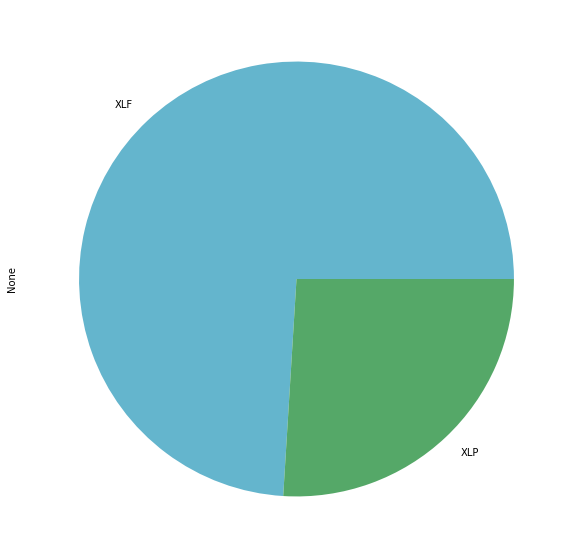

In [ ]:
# Calculamos los rendimientos esperados y la matriz de covarianza
mu = expected_returns.mean_historical_return(data_past)
S = risk_models.sample_cov(data_past)

# Optimización de Sharpe Ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
volatility = ef.portfolio_performance()[1]
returns = ef.portfolio_performance()[0]
sharpe_ratio = ef.portfolio_performance()[2]


# Resultados
print("Pesos del portafolio:")
print(cleaned_weights)
print("Volatilidad anual del portafolio: {:.2f}".format(volatility))
print("Rendimiento anual del portafolio: {:.2f}".format(returns))
print("Sharpe Ratio del portafolio: {:.2f}".format(sharpe_ratio))
pd.Series(cleaned_weights).plot.pie(figsize=(10, 10))

Bajo este modelo los resultados indican que el 73% del capital se aloćo al ETF de Financial Sector y el restante del portafolio al ETF de Consumer Staples. La volatilidad anual del portafolio es del 16% y el rendimiento anual es del 9%. El Sharpe Ratio del portafolio es de 0.48.

Si bien este resultado nos pareció interesante, creímos que sería relevante tomar dos puntos más en cuenta:

En primer lugar, nos pareció que teniendo una cartera de 14 activos, utilizar solo 2 implicaría una muy baja diversificación, posiblemente una solución que funcionaría mal out of sample. Es por esto que decidimos adaptar la función objetivo añandiendo una función de costo adicional añandiendo lo que puede considerarse como una "penalización por pesos pequeños" a la función objetivo, parametrizada por gamma, la cual funciona de manera similar a la regularización L2 tan utilizada en machine learning.

En segundo lugar, si bien el objetivo en este modelo es maximizar el Sharpe Ratio, se nos ocurrió evaluar cómo fluctuaba este índice a distintos valores de porcentaje de volatilidad. Entendiendo que si bien se prioriza la maximización del índice, también es relevante tener otros factores en cuenta. Para esto llevamos a cabo una iteración donde pudimos analizar para 50 valores distintos de volatilidad máxima entre 6% y 70%, poniendo como función objetivo la minimización de la volatilidad, pero buscando encontrar el valor máximo de Sharpe Ratio posible.

#### Optimización con criterio de frontera eficiente

In [ ]:
# Buscamos encontrar la maximización del sharpe ratio pero teniendo en cuenta una minimización de la volatilitdad.
# Iteramos para 50 números entre 0.1 y 0.7 como valores máximos de volatilidad hasta encontrar el máximo Sharpe Ratio.
# Al ser tan grande el rango de volatilidad nos aseguramos que podremos ver todo el comportamiento del Sharpe Ratio y seguir obteniendo el óptimo.
sharpe_ratios = []
vol_limits = []
for i in np.linspace(0.06,0.7,num = 50):
  vol_limit = i

  ef = EfficientFrontier(mu, S)
  ef.add_objective(objective_functions.L2_reg, gamma=0.1)
  weights = ef.efficient_risk(vol_limit)
  cleaned_weights = ef.clean_weights()
  volatility = ef.portfolio_performance()[1]
  returns = ef.portfolio_performance()[0]
  sharpe_ratio = ef.portfolio_performance()[2]
  sharpe_ratios.append(sharpe_ratio)
  vol_limits.append(i)
  # Resultados
  print("El vol limit es :" , i)
  print("Volatilidad anual del portafolio: {:.2f}%".format(volatility * 100))
  print("Rendimiento anual del portafolio: {:.2f}%".format(returns * 100))
  print("Sharpe Ratio del portafolio: {:.2f}".format(sharpe_ratio))
  print('-----------------------------------')


El vol limit es : 0.06
Volatilidad anual del portafolio: 6.00%
Rendimiento anual del portafolio: 3.00%
Sharpe Ratio del portafolio: 0.17
-----------------------------------
El vol limit es : 0.07306122448979592
Volatilidad anual del portafolio: 7.31%
Rendimiento anual del portafolio: 4.27%
Sharpe Ratio del portafolio: 0.31
-----------------------------------
El vol limit es : 0.08612244897959183
Volatilidad anual del portafolio: 8.61%
Rendimiento anual del portafolio: 5.20%
Sharpe Ratio del portafolio: 0.37
-----------------------------------
El vol limit es : 0.09918367346938775
Volatilidad anual del portafolio: 9.92%
Rendimiento anual del portafolio: 5.99%
Sharpe Ratio del portafolio: 0.40
-----------------------------------
El vol limit es : 0.11224489795918366
Volatilidad anual del portafolio: 11.22%
Rendimiento anual del portafolio: 6.71%
Sharpe Ratio del portafolio: 0.42
-----------------------------------
El vol limit es : 0.1253061224489796
Volatilidad anual del portafolio: 12.

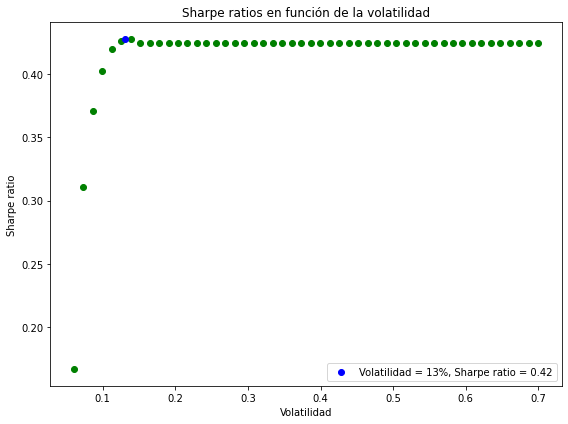

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(vol_limits, sharpe_ratios, c="g")
plt.scatter(0.13, max(sharpe_ratios), color='blue', label = 'Volatilidad = 13%, Sharpe ratio = 0.42') # Graficamos el punto de mayor Sharpe Ratio según la iteración en color azul
ax.set_title("Sharpe ratios en función de la volatilidad")
plt.xlabel('Volatilidad')
plt.ylabel('Sharpe ratio')
ax.legend()
plt.tight_layout()
plt.show()

Pesos del portafolio:
OrderedDict([('AAPL', 0.10058), ('ARKK', 0.0), ('EEM', 0.0), ('EWZ', 0.0), ('FEZ', 0.0), ('FXI', 0.0), ('GLD', 0.0), ('HYG', 0.00845), ('SPY', 0.17936), ('TLT', 0.0), ('XLE', 0.0), ('XLF', 0.34801), ('XLI', 0.22133), ('XLP', 0.14227)])
Volatilidad anual del portafolio: 0.14
Rendimiento anual del portafolio: 0.08
Sharpe Ratio del portafolio: 0.43


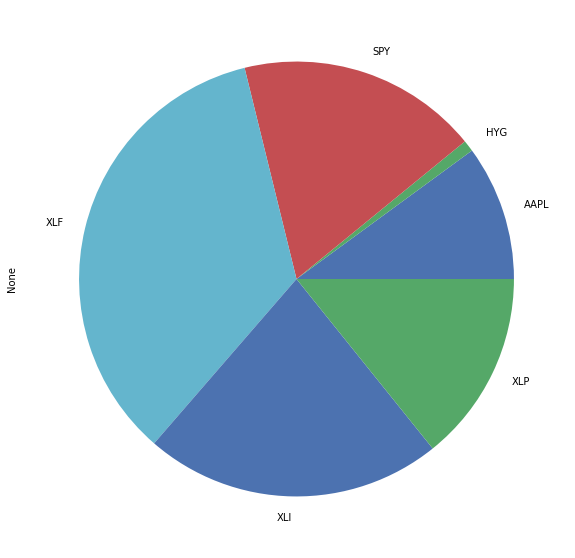

In [ ]:
# Modelamos con el óptimo que se asocia a un limite de volatilidad de 0.173469.
# Calcular los rendimientos esperados y la matriz de covarianza

vol_limit = 0.1383673469387755

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1) # Utilizamos una función objetivo de L2 regularization para castigar los pesos nulos y sumar algunos activos más
weights = ef.efficient_risk(vol_limit)
cleaned_MS_weights = ef.clean_weights()
volatility = ef.portfolio_performance()[1]
returns = ef.portfolio_performance()[0]
sharpe_ratio = ef.portfolio_performance()[2]


# Resultados
print("Pesos del portafolio:")
print(cleaned_weights)
print("Volatilidad anual del portafolio: {:.2f}".format(volatility))
print("Rendimiento anual del portafolio: {:.2f}".format(returns))
print("Sharpe Ratio del portafolio: {:.2f}".format(sharpe_ratio))
pd.Series(cleaned_weights).plot.pie(figsize=(10, 10))

list_of_portfolios = {'HRP': dict(hrp_weights), 'Max Sharpe': dict(cleaned_MS_weights)}


### Classic 60-40

La estrategia 60-40 es una estrategia de inversión en la que se asigna el 60% de los fondos a acciones y el 40% restante a bonos. La idea detrás de esta estrategia es lograr un equilibrio entre la rentabilidad y el riesgo de la cartera.

Las acciones son activos más riesgosos que los bonos, pero también tienen un mayor potencial de rentabilidad a largo plazo. Por otro lado, los bonos son activos más seguros que las acciones, pero generalmente tienen una rentabilidad más baja. Al combinar estos dos tipos de activos en una proporción 60-40, se busca lograr una cartera con una rentabilidad razonablemente alta y un riesgo moderado.


Pesos del portafolio:  OrderedDict([('AAPL', 0.10058), ('ARKK', 0.0), ('EEM', 0.0), ('EWZ', 0.0), ('FEZ', 0.0), ('FXI', 0.0), ('GLD', 0.0), ('HYG', 0.00845), ('SPY', 0.17936), ('TLT', 0.0), ('XLE', 0.0), ('XLF', 0.34801), ('XLI', 0.22133), ('XLP', 0.14227)])
Volatilidad anual del portafolio: 10.95%
Rendimiento anual del portafolio: 6.72%
Sharpe Ratio del portafolio: 0.43


/usr/local/lib/python3.8/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


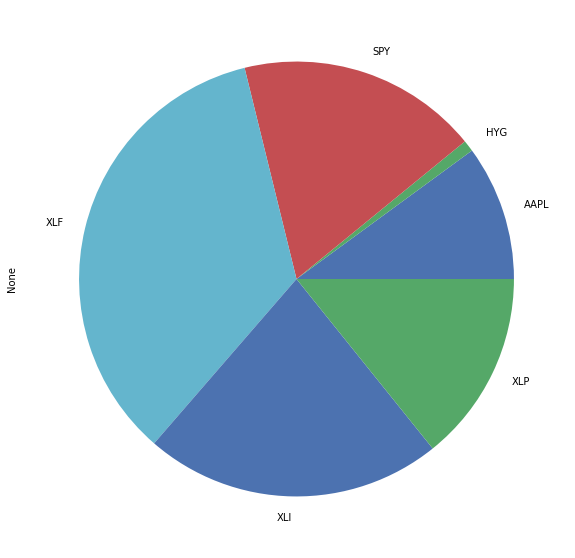

In [ ]:
# Para la optimización del portfolio añadimos una restricción la cual indica porcentajes mínimos y máximos en la distribución de activos según su clasificación (bono o acción)

sector_mapper = {
    "TLT": "BONO",
    "HYG": "BONO",
    'SPY': 'ACCION',
    "AAPL": "ACCION",
    "EEM": "ACCION",
    "GLD": "METALES",
    "FXI": 'ACCION',
    'XLF': 'ACCION',
    'EWZ': 'ACCION',
    'ARKK': 'ACCION',
    'XLE': 'ACCION',
    'XLP': 'ACCION',
    'XLI': 'ACCION',
    'FEZ': 'ACCION'

}
sector_lower = {"BONO": 0.39, "ACCION": 0.59}  # mínimo 39% bonos y 59% acciones
sector_upper = {"BONO": 0.41, "ACCION": 0.61} # máximo 41% bonos y 61% acciones


# Calcular los rendimientos esperados y la matriz de covarianza
mu = expected_returns.mean_historical_return(data_past)
S = risk_models.sample_cov(data_past)


ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1) # Utilizamos L2 regularization para castigar los pesos nulos y diversificar nuestra cartera
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper) # Restricción de mínimos y máximos %
weights = ef.max_sharpe()
cleaned_weights_6040 = ef.clean_weights()
volatility = ef.portfolio_performance()[1]
returns = ef.portfolio_performance()[0]
sharpe_ratio = ef.portfolio_performance()[2]


# Resultados
print("Pesos del portafolio: ", cleaned_weights)
print("Volatilidad anual del portafolio: {:.2f}%".format(volatility * 100))
print("Rendimiento anual del portafolio: {:.2f}%".format(returns * 100))
print("Sharpe Ratio del portafolio: {:.2f}".format(sharpe_ratio))
pd.Series(cleaned_weights).plot.pie(figsize=(10, 10))

list_of_portfolios = {'HRP': dict(hrp_weights), 'Max Sharpe': dict(cleaned_MS_weights), '6040': dict(cleaned_weights_6040)}


### Global Minimum Variance - GMV

Pesos del portafolio:
OrderedDict([('AAPL', 0.10058), ('ARKK', 0.0), ('EEM', 0.0), ('EWZ', 0.0), ('FEZ', 0.0), ('FXI', 0.0), ('GLD', 0.0), ('HYG', 0.00845), ('SPY', 0.17936), ('TLT', 0.0), ('XLE', 0.0), ('XLF', 0.34801), ('XLI', 0.22133), ('XLP', 0.14227)])
Volatilidad anual del portafolio: 5.74
Rendimiento anual del portafolio: 2.36
Sharpe Ratio del portafolio: 0.06


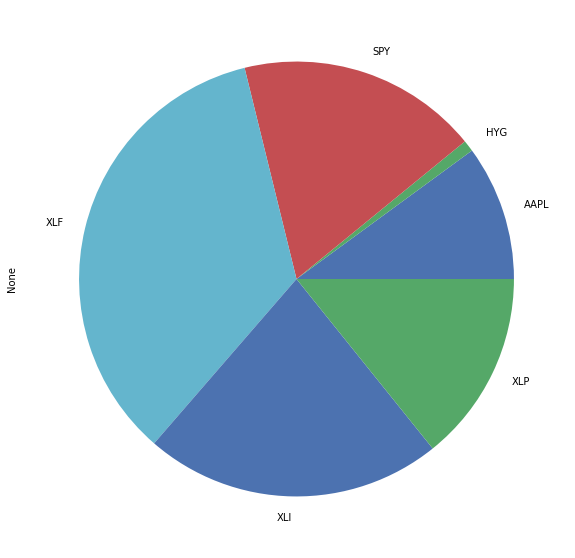

In [ ]:
# Buscamos encontrar la maximización del sharpe ratio pero teniendo en cuenta una minimización de la volatilitdad.
# Iteramos para 50 números entre 0.1 y 0.7 como valores máximos de volatilidad hasta encontrar el máximo Sharpe Ratio.
# Al ser tan grande el rango de volatilidad nos aseguramos que podremos ver todo el comportamiento del Sharpe Ratio y seguir obteniendo el óptimo.

mu = expected_returns.mean_historical_return(data_past)
S = risk_models.sample_cov(data_past)
ef = EfficientFrontier(mu, S)

# Solicitamos que el riesgo sea el objetivo principal de la optimización
#ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.min_volatility()
cleaned_weights_gmv = ef.clean_weights()
volatility = ef.portfolio_performance()[1]
returns = ef.portfolio_performance()[0]
sharpe_ratio = ef.portfolio_performance()[2]


# Resultados
print("Pesos del portafolio:")
print(cleaned_weights)
print("Volatilidad anual del portafolio: {:.2f}".format(volatility * 100))
print("Rendimiento anual del portafolio: {:.2f}".format(returns * 100))
print("Sharpe Ratio del portafolio: {:.2f}".format(sharpe_ratio))
pd.Series(cleaned_weights).plot.pie(figsize=(10, 10))
list_of_portfolios = {'HRP': dict(hrp_weights), 'Max Sharpe': dict(cleaned_MS_weights), '6040': dict(cleaned_weights_6040), 'GMV':cleaned_weights_gmv}

In [ ]:
# Buscamos encontrar la maximización del sharpe ratio pero teniendo en cuenta una minimización de la volatilitdad
# Iteramos para 50 números entre 0.1 y 0.7 como valores máximos de volatilidad hasta encontrar el máximo Sharpe Ratio.
# Al ser tan grande el rango de volatilidad nos aseguramos que podremos ver todo el comportamiento del Sharpe Ratio y seguir obteniendo el óptimo.
sharpe_ratios = []
vol_limits = []
for i in np.linspace(0.08,0.4,num = 50):
  vol_limit = i

  # Optimización de Markowitz
  ef = EfficientFrontier(mu, S)
  #ef.add_constraint(lambda w: w >= 0.001)  # restricción de peso mínimo por activo
  ef.add_objective(objective_functions.L2_reg, gamma=0.1)
  weights = ef.efficient_risk(vol_limit)
  cleaned_weights = ef.clean_weights()
  volatility = ef.portfolio_performance()[1]
  returns = ef.portfolio_performance()[0]
  sharpe_ratio = ef.portfolio_performance()[2]
  sharpe_ratios.append(sharpe_ratio)
  vol_limits.append(i)
  # Resultados
  print("El vol limit es :" , i)
  print("Volatilidad anual del portafolio: {:.2f}%".format(volatility * 100))
  print("Rendimiento anual del portafolio: {:.2f}%".format(returns * 100))
  print("Sharpe Ratio del portafolio: {:.2f}".format(sharpe_ratio))
  print('-----------------------------------')


El vol limit es : 0.08
Volatilidad anual del portafolio: 8.00%
Rendimiento anual del portafolio: 4.78%
Sharpe Ratio del portafolio: 0.35
-----------------------------------
El vol limit es : 0.08653061224489796
Volatilidad anual del portafolio: 8.65%
Rendimiento anual del portafolio: 5.22%
Sharpe Ratio del portafolio: 0.37
-----------------------------------
El vol limit es : 0.09306122448979592
Volatilidad anual del portafolio: 9.31%
Rendimiento anual del portafolio: 5.63%
Sharpe Ratio del portafolio: 0.39
-----------------------------------
El vol limit es : 0.09959183673469388
Volatilidad anual del portafolio: 9.96%
Rendimiento anual del portafolio: 6.01%
Sharpe Ratio del portafolio: 0.40
-----------------------------------
El vol limit es : 0.10612244897959183
Volatilidad anual del portafolio: 10.61%
Rendimiento anual del portafolio: 6.38%
Sharpe Ratio del portafolio: 0.41
-----------------------------------
El vol limit es : 0.1126530612244898
Volatilidad anual del portafolio: 11.

Pesos del portafolio:
OrderedDict([('AAPL', 0.0542), ('ARKK', 0.0), ('EEM', 0.0), ('EWZ', 0.0), ('FEZ', 0.0), ('FXI', 0.0), ('GLD', 0.21938), ('HYG', 0.29768), ('SPY', 0.0), ('TLT', 0.23044), ('XLE', 0.0), ('XLF', 0.04761), ('XLI', 0.0), ('XLP', 0.15069)])
Volatilidad anual del portafolio: 8.00%
Rendimiento anual del portafolio: 4.66%
Sharpe Ratio del portafolio: 0.33
-----------------------------------


<AxesSubplot:ylabel='None'>

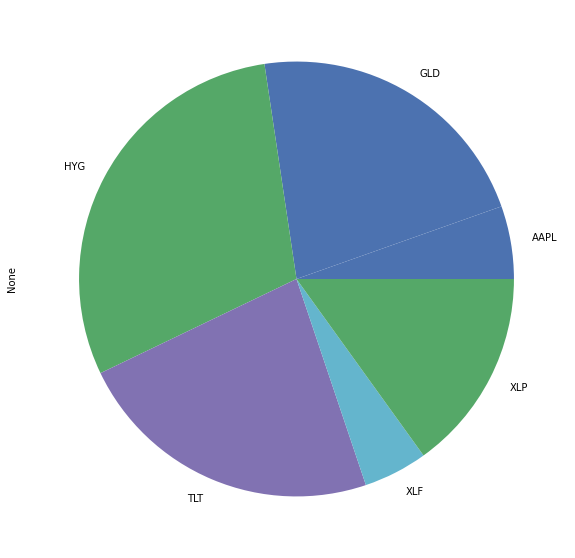

In [ ]:
# Modelamos con el óptimo que se asocia a un limite de volatilidad de 0.173469.
mu = expected_returns.mean_historical_return(prices_df)
S = risk_models.sample_cov(prices_df)

vol_limit = 0.08

# Optimización de Markowitz
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1) # Utilizamos una función objetivo de L2 regularization para castigar los pesos nulos y sumar algunos activos más
weights = ef.efficient_risk(vol_limit)
cleaned_weights = ef.clean_weights()
volatility = ef.portfolio_performance()[1]
returns = ef.portfolio_performance()[0]
sharpe_ratio = ef.portfolio_performance()[2]


# Resultados
print("Pesos del portafolio:")
print(cleaned_weights)
print("Volatilidad anual del portafolio: {:.2f}%".format(volatility * 100))
print("Rendimiento anual del portafolio: {:.2f}%".format(returns * 100))
print("Sharpe Ratio del portafolio: {:.2f}".format(sharpe_ratio))
print('-----------------------------------')

pd.Series(cleaned_weights).plot.pie(figsize=(10, 10))

Pesos del portafolio:
OrderedDict([('AAPL', 0.16378), ('ARKK', 0.0), ('EEM', 0.0), ('EWZ', 0.0), ('FEZ', 0.0), ('FXI', 0.0), ('GLD', 0.24768), ('HYG', 0.14058), ('SPY', 0.0224), ('TLT', 0.19022), ('XLE', 0.0), ('XLF', 0.04384), ('XLI', 0.03106), ('XLP', 0.16045)])
Volatilidad anual del portafolio: 10.00%
Rendimiento anual del portafolio: 7.52%
Sharpe Ratio del portafolio: 0.55
-----------------------------------


<AxesSubplot:ylabel='None'>

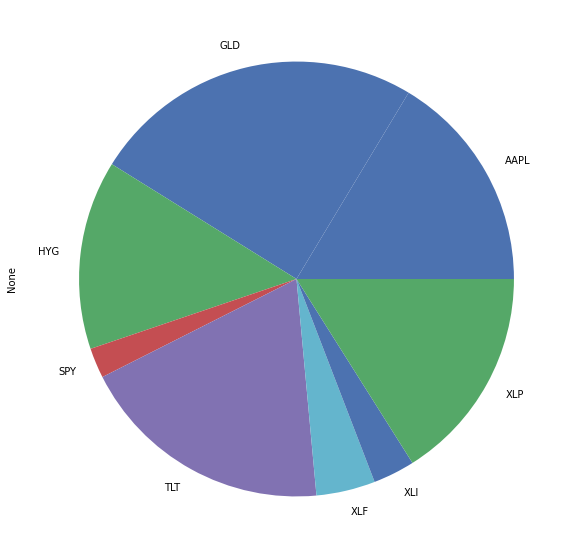

In [ ]:
# Calcular los rendimientos esperados y la matriz de covarianza
mu = expected_returns.mean_historical_return(prices_df)
S = risk_models.sample_cov(prices_df)

vol_limit = 0.1

# Optimización de Markowitz
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1) # Utilizamos una función objetivo de L2 regularization para castigar los pesos nulos y sumar algunos activos más
weights = ef.efficient_risk(vol_limit)
cleaned_weights = ef.clean_weights()
volatility = ef.portfolio_performance()[1]
returns = ef.portfolio_performance()[0]
sharpe_ratio = ef.portfolio_performance()[2]


# Resultados
print("Pesos del portafolio:")
print(cleaned_weights)
print("Volatilidad anual del portafolio: {:.2f}%".format(volatility * 100))
print("Rendimiento anual del portafolio: {:.2f}%".format(returns * 100))
print("Sharpe Ratio del portafolio: {:.2f}".format(sharpe_ratio))
print('-----------------------------------')

pd.Series(cleaned_weights).plot.pie(figsize=(10, 10))

## Ejercicio 2: Montecarlo simulations for all portfolios

Pasos a seguir:

1. Construir matriz de covarianza denoise and detoned para los activos listados (llamemosla R)
2. Descomponer R en c*c^T = R según Cholesky *1
3. Pasarle una matriz de números generados aleatoriamente de forma de que podamos obtener retornos simulados para el listado de activos que respete la correlación que se encontró
4. En el in-sample, tomar 100 simulaciones de MC para cada portfolio y calcular sus métricas simuladas. A su vez, compararlas con el resultado real.
5. Realizar 4 para los datos out of sample

In [ ]:
## Funciones auxiliares; probablemente alguna no sea usada.

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr
#---------------------------------------------------

def corr2cov(corr,std):
    # Derive the covariance matrix from a correlation matrix
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    cov = np.outer(std,std)*corr
    return cov
#---------------------------------------------------
def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec
#---------------------------------------------------
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    var = var[0]
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    #import pdb; pdb.set_trace()
    sse=np.sum((pdf1-pdf0)**2)
    return sse
#---------------------------------------------------
def findMaxEval(eVal,q,bWidth):
# Find max random eVal by fitting Marcenko’s dist
    out=minimize(lambda *x: errPDFs(*x),.5,args=(eVal,q,bWidth),bounds=((1E-5,1-1E-5),))
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var
#---------------------------------------------------
def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    # when var= 1, C = T^-1 X'X  is the correlation matrix associated with X
    # lambda+ =,lambda- = eMax, eMin
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    #pdf = pdf.ravel()
    pdf=pd.Series(pdf,index=eVal)
    return pdf
#---------------------------------------------------
def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:
        obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:
        x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf
#---------------------------------------------------
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts) # average the rest
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1
#---------------------------------------------------
def detone(c1,n_markets=1):
    from numpy.linalg import eig
    from numpy.linalg import matrix_power
    w,v=eig(c1)
    mat_v=np.matrix(v[0:n_markets])
    mat_w=np.matrix(w[0:n_markets])
    c2_hat=(c1-mat_v.T@mat_w@mat_v)
    c2=c2_hat@np.linalg.inv(np.diag(np.diag(c2_hat)))
    return c2

#---------------------------------------------------

def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

In [ ]:
## Atención: todo en formato diario
q = 10

# Denoise cov_returns
denoised_cov_past = deNoiseCov(cov_matrix_past,q,bWidth = .01)

# Detone cov_returns
detoned_cov_past = detone(c1=denoised_cov_past)

## Hay algún problema en el detoning porque cuando aplico el detoning me dice que el array no es positivo y no puede hacer la descomposición de cholesky
## Chequeamos y corregimos la matriz de covarianza es positiva semidefinida de forma de poder hacer una descomposición de cholesky luego
cov_detoned_denoised_past = risk_models.fix_nonpositive_semidefinite(detoned_cov_past, fix_method='diag')

## Descomposición de cholesky para poder correlacionar los retornos de los N activos en la simulación de montecarlo
c = cholesky(cov_matrix_past, lower=True)
# print(c.shape) #Matriz de N x N

/usr/local/lib/python3.8/dist-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


In [ ]:
asset_means = returns_past.mean()
asset_std = returns_past.std()
prices_init_train = data_past.iloc[-1]
prices_init_train_dict = prices_init_train.to_dict()
df_simulated_prices = []
np.random.seed(42)
x = np.random.normal(size=(1, n_assets))                  #en cada simulación, genero una matriz de N números aleatorios a través de una normal
y = (np.matmul(c, np.transpose(x)))                       #correlaciono estos números aleatorios a través de la c de la decomp de Cholesky
print(y.shape)

(14, 1)


#### Ejercicios in-sample
Se usan, para la simulación mensual, los datos 'past' y se toma como t0 al inicio del dataset

In [ ]:
asset_means = returns_past.mean()
len_simulation = 10
len_fecha = 30
prices_init_train = data_past.iloc[0]
precios_simulados = []

for j in [0]:
  x = np.random.normal(size=(1, n_assets))
  y = (np.matmul(c, np.transpose(x)))

  for z in range(len_simulation):
    for k in range(len(y)):
      price_final_activo = prices_init_train[k] * np.exp((asset_means[k] - 0.5 * asset_std[k] ** 2) * (1) + asset_std[k] * np.sqrt(1) * y[k])
      price_final_activo = float(price_final_activo)
      apendeo = [z,k,j,price_final_activo]
      precios_simulados.append(apendeo)
  precios_simulados = pd.DataFrame(precios_simulados)
  precios_simulados.columns = ['Sim','Activo','Fecha','Precio Simulado']

for j in range(1,len_fecha):
  for z in range(len_simulation):
    prices_init_train = precios_simulados[(precios_simulados['Fecha']==j-1) & (precios_simulados['Sim'] == z)]
    x = np.random.normal(size=(1, n_assets))
    y = (np.matmul(c, np.transpose(x)))
    for k in range(len(y)):
      price_final_activo = prices_init_train['Precio Simulado'][prices_init_train['Activo']==k] * np.exp((asset_means[k] - 0.5 * asset_std[k] ** 2) * (1) + asset_std[k] * np.sqrt(1) * y[k])
      price_final_activo = float(price_final_activo)
      precios_simulados = precios_simulados.append({'Activo':k, 'Fecha':j, 'Precio Simulado':price_final_activo, 'Sim': z},ignore_index = True)


In [ ]:
# Aprox 8 minutos para 50 simulaciones
# Hacemos transformaciones al df precios_simulados para agregar información real de precios
# Cuidado: si se hace con 100 simulaciones el tiempo de corrida supera los 10 minutos. Mejor setear la celda anterior en pocas simulaciones

dict_asset = {0:'AAPL', 1:'ARKK', 2:'EEM',3:'EWZ',4:'FEZ',5:'FXI',6:'GLD',7:'HYG',8:'SPY',9:'TLT',10:'XLE',11:'XLF',12:'XLI',13:'XLP'}
precios_simulados = precios_simulados.replace({"Activo": dict_asset})
precios_simulados['Fecha'] = precios_simulados['Fecha'].astype('int')
precios_simulados['Precios Reales'] = np.zeros(len(precios_simulados))

for i in range(len(precios_simulados)):
  activo = precios_simulados['Activo'][i]
  fecha = precios_simulados['Fecha'][i]
  precios_simulados['Precios Reales'][i] = data_past[activo][fecha]

# Hacemos transformaciones al df precios_simulados para agregar información de retornos en USD y en %
precios_simulados['Retornos Sim USD'] = np.zeros(len(precios_simulados))
precios_simulados['Retornos Reales USD'] = np.zeros(len(precios_simulados))
precios_simulados['Retornos % Sim'] = np.zeros(len(precios_simulados))
precios_simulados['Retornos % Reales'] = np.zeros(len(precios_simulados))

for i in range(len(precios_simulados)):
  activo = precios_simulados['Activo'][i]
  fecha = precios_simulados['Fecha'][i]
  sim = precios_simulados['Sim'][i]
  if fecha == 0:
    pass
  else:
    precios_simulados['Retornos Sim USD'][i] = float(precios_simulados['Precio Simulado'][(precios_simulados['Activo']==activo) & (precios_simulados['Sim']==sim)  & (precios_simulados['Fecha']==fecha)])-float(precios_simulados['Precio Simulado'][(precios_simulados['Activo']==activo) & (precios_simulados['Sim']==sim) & (precios_simulados['Fecha']==fecha-1)])
    precios_simulados['Retornos Reales USD'][i] = float(precios_simulados['Precios Reales'][(precios_simulados['Activo']==activo) & (precios_simulados['Sim']==sim) &(precios_simulados['Fecha']==fecha)])-float(precios_simulados['Precios Reales'][(precios_simulados['Activo']==activo) & (precios_simulados['Sim']==sim) & (precios_simulados['Fecha']==fecha-1)])
    precios_simulados['Retornos % Sim'][i] = float(precios_simulados['Retornos Sim USD'][(precios_simulados['Activo']==activo) & (precios_simulados['Sim']==sim)  & (precios_simulados['Fecha']==fecha)])/float(precios_simulados['Precio Simulado'][(precios_simulados['Activo']==activo) & (precios_simulados['Sim']==sim) & (precios_simulados['Fecha']==fecha-1)])
    precios_simulados['Retornos % Reales'][i] = float(precios_simulados['Retornos Reales USD'][(precios_simulados['Activo']==activo) & (precios_simulados['Sim']==sim)  & (precios_simulados['Fecha']==fecha)])/float(precios_simulados['Precios Reales'][(precios_simulados['Activo']==activo) & (precios_simulados['Sim']==sim) & (precios_simulados['Fecha']==fecha-1)])

<ipython-input-36-aa8128800cce>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precios_simulados['Precios Reales'][i] = data_past[activo][fecha]
<ipython-input-36-aa8128800cce>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precios_simulados['Retornos Sim USD'][i] = float(precios_simulados['Precio Simulado'][(precios_simulados['Activo']==activo) & (precios_simulados['Sim']==sim)  & (precios_simulados['Fecha']==fecha)])-float(precios_simulados['Precio Simulado'][(precios_simulados['Activo']==activo) & (precios_simulados['Sim']==sim) & (precios_simulados['Fecha']==fecha-1)])
<ipython-input-36-aa8128800cce>:29: Sett

EVOLUCIÓN DE AAPL


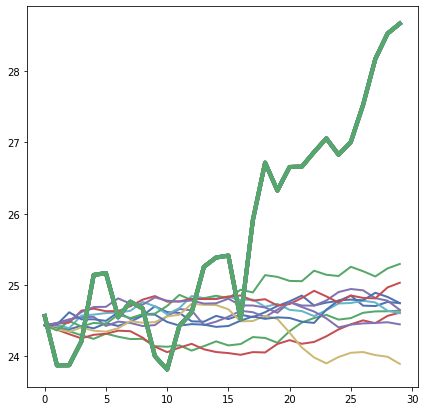

EVOLUCIÓN DE SPY


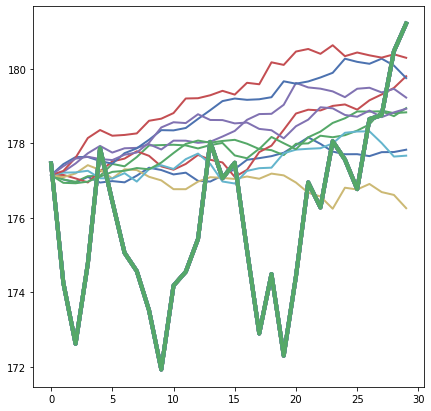

EVOLUCIÓN DE EEM


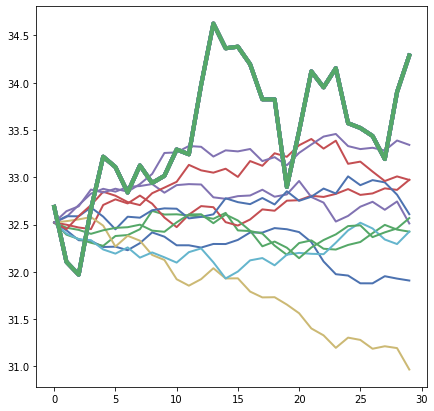

EVOLUCIÓN DE GLD


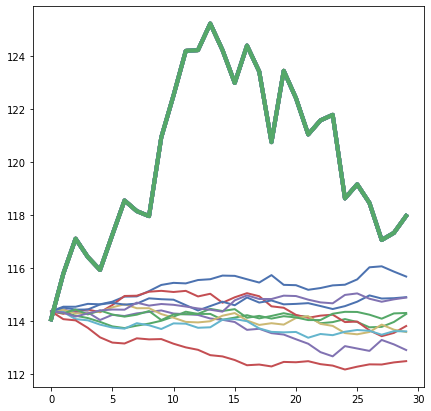

EVOLUCIÓN DE FXI


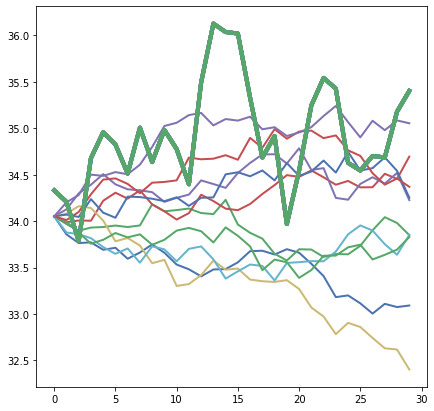

EVOLUCIÓN DE XLF


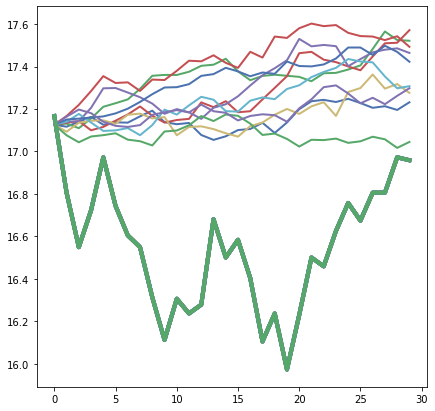

EVOLUCIÓN DE EWZ


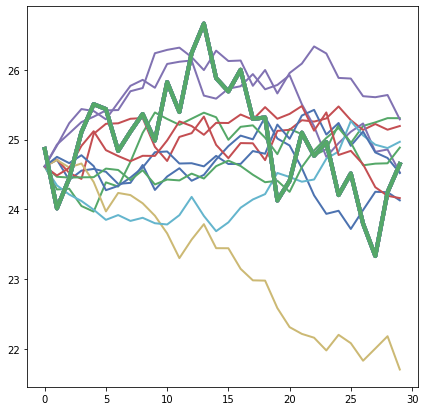

EVOLUCIÓN DE ARKK


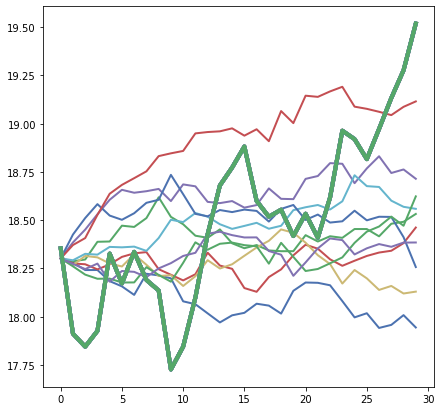

EVOLUCIÓN DE XLE


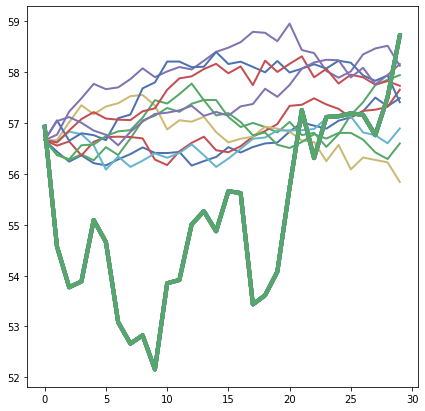

EVOLUCIÓN DE TLT


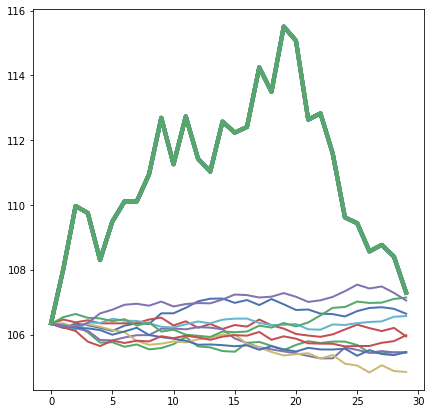

EVOLUCIÓN DE XLP


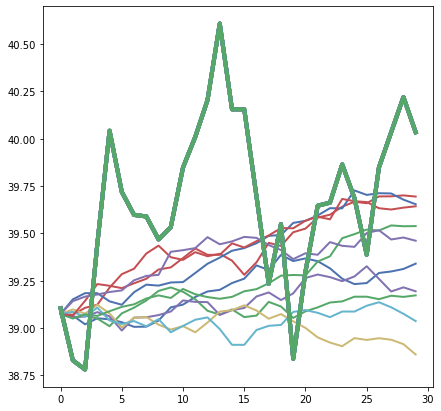

EVOLUCIÓN DE XLI


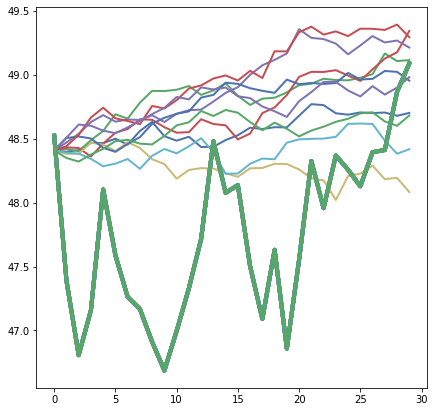

EVOLUCIÓN DE FEZ


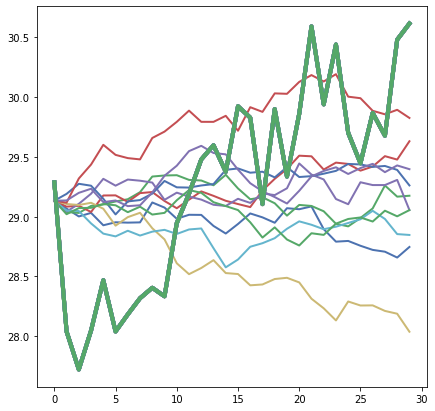

EVOLUCIÓN DE HYG


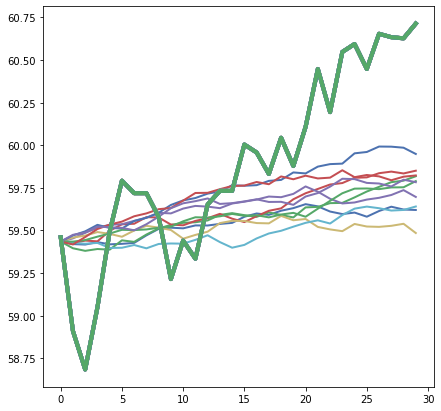

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 7)
#Ploteo los activos sim vs real para ver como están

for i in RISKY_ASSETS:
  print(f'EVOLUCIÓN DE {i}')
  i = precios_simulados[precios_simulados['Activo']==i]
  plt.plot(pd.pivot_table(i.reset_index(),
               index='Fecha', columns='Sim', values='Precio Simulado'
              ),linewidth = 2)
  plt.plot(pd.pivot_table(i.reset_index(),
               index='Fecha', columns='Sim', values='Precios Reales'
              ),linewidth = 4)
  plt.show()

Podemos observar que, salvo XLI, TLT, XLE, EWZ todo el resto de los activos termino en la cota superior de las simulaciones de montecarlo. Es de esperar que tengamos distintos rendimientos para los portafolios entre lo simulado y lo real

In [ ]:
%matplotlib inline

equally_weighted = {'AAPL':1/14, 'SPY':1/14, 'EEM':1/14 ,'GLD':1/14, 'FXI':1/14, 'XLF': 1/14,'EWZ':1/14,'ARKK':1/14,'XLE':1/14,'TLT':1/14,'XLP':1/14,'XLI':1/14,'FEZ':1/14,'HYG':1/14}

list_of_portfolios = {'HRP': dict(hrp_weights), 'Max Sharpe': dict(cleaned_MS_weights), '6040': dict(cleaned_weights_6040), 'GMV':cleaned_weights_gmv, 'naive': equally_weighted}

df_portfolio_columns=[]

for key in list_of_portfolios.keys():
  precios_simulados[f'weights_{key}'] = precios_simulados['Activo'].map(list_of_portfolios[key])
  precios_simulados[f'weighted_sim_returns_{key}'] = precios_simulados['Retornos % Sim']*precios_simulados[f'weights_{key}']
  precios_simulados[f'weighted_real_returns_{key}'] = precios_simulados['Retornos % Reales']*precios_simulados[f'weights_{key}']

  df_portfolio_columns.append(f'weighted_returns_{key}')

In [ ]:
#Calculamos los retornos de 30 días de trading
df_portfolio_sim_columns = ['weighted_sim_returns_HRP', 'weighted_sim_returns_Max Sharpe', 'weighted_sim_returns_6040', 'weighted_sim_returns_GMV', 'weighted_sim_returns_naive']
df_portfolio_real_columns = ['weighted_real_returns_HRP', 'weighted_real_returns_Max Sharpe', 'weighted_real_returns_6040', 'weighted_real_returns_GMV', 'weighted_real_returns_naive']
risk_free  = 0.00165 ##tasa mensualizada del 2%

portfolio_sim_returns = []
for z in range(len_simulation): #Selecciono simulación
  precios_simulados_selected = precios_simulados[precios_simulados['Sim']==z]
  for i in df_portfolio_sim_columns: #Para cada simulación, simulo retorno promedio del portfolio
    retorno_medio = precios_simulados_selected[i].sum()
    portfolio_sim_returns.append([z, i , retorno_medio])

portfolio_real_returns = []
for z in range(1): #Selecciono simulación
  precios_reales_selected = precios_simulados[precios_simulados['Sim']==z]
  for i in df_portfolio_real_columns: #Para cada simulación, simulo retorno promedio del portfolio
    retorno_medio = precios_reales_selected[i].sum()
    portfolio_real_returns.append([z, i , retorno_medio])

portfolio_sim_returns = pd.DataFrame(portfolio_sim_returns)
portfolio_sim_returns.columns = ['Sim','Portfolio','Ret']

portfolio_real_returns = pd.DataFrame(portfolio_real_returns)
portfolio_real_returns.columns = ['Sim','Portfolio','Ret']

stats = []
for i in df_portfolio_sim_columns:
  selected_portfolio = portfolio_sim_returns[portfolio_sim_returns['Portfolio']==i]
  mean = selected_portfolio['Ret'].mean()

  vol = []
  for j in range(len(selected_portfolio)):
    vol_2 = (selected_portfolio.iloc[[j]]['Ret']-mean)**2
    vol_2 = float(vol_2)
    vol.append(vol_2)
  vol = sum(vol)
  vol = np.sqrt(vol/len(selected_portfolio))
  apendeo = [i, mean*100, vol*100]
  stats.append(apendeo)


stats_real = []
for i in df_portfolio_real_columns:
  selected_portfolio = portfolio_real_returns[portfolio_real_returns['Portfolio']==i]
  mean = selected_portfolio['Ret'].mean()
  vol = []
  for j in range(len(selected_portfolio)):
    vol_2 = (selected_portfolio.iloc[[j]]['Ret']-mean)**2
    vol_2 = float(vol_2)
    vol.append(vol_2)
  vol = sum(vol)
  vol = np.sqrt(vol/len(selected_portfolio))
  apendeo = [i, mean*100, vol*100]
  stats_real.append(apendeo)


stats = pd.DataFrame(stats)
stats.columns = ['Portfolio','Return','Desvio']
stats['Sharpe'] = (stats['Return'] - risk_free*100)/stats['Desvio']

stats_real = pd.DataFrame(stats_real)
stats_real.columns = ['Portfolio','Return','Desvio']
stats_real['Sharpe'] = (stats_real['Return'] - risk_free*100)/stats_real['Desvio']

print('Todos los valores son % mensuales')
print('Portafolios simulados')
print(stats)
print("")
print("#################")
print("")
print('Portfolios Reales')
print(stats_real)

Todos los valores son % mensuales
Portafolios simulados
                         Portfolio    Return    Desvio    Sharpe
0         weighted_sim_returns_HRP  0.343715  0.524327  0.340847
1  weighted_sim_returns_Max Sharpe  1.004845  0.604891  1.388423
2        weighted_sim_returns_6040  0.855777  0.465956  1.482492
3         weighted_sim_returns_GMV  0.311251  0.250072  0.584837
4       weighted_sim_returns_naive  0.427372  1.044673  0.251153

#################

Portfolios Reales
                          Portfolio    Return  Desvio  Sharpe
0         weighted_real_returns_HRP  2.763831     0.0     inf
1  weighted_real_returns_Max Sharpe  2.039489     0.0     inf
2        weighted_real_returns_6040  1.019984     0.0     inf
3         weighted_real_returns_GMV  1.806035     0.0     inf
4       weighted_real_returns_naive  3.637553     0.0     inf


## Ejercicio 3: Una aproximación a targeted-date portfolios



Se correrán dos estrategias
1. Una estrategia siguiendo al [paper de Martellini](https://climateimpact.edhec.edu/precision-investing-optimal-design-personalized) donde se corren distintas proporciones del portfolio GMV y el portfolio MSR de forma fija por 1 año

2. Una estrategia que corre 1 con distintos tiempos de corte: por ejemplo, en fechas 63, 126 y 189 la estrategia 70%/30% MSR/GMV a 60/40

             Portfolio    Return       Vol    Sharpe
0  Portf_10_MSR_90_GMV  0.380611  0.259328  0.831421
1  Portf_20_MSR_80_GMV  0.449970  0.278674  1.022591
2  Portf_30_MSR_70_GMV  0.519329  0.306205  1.157163
3  Portf_40_MSR_60_GMV  0.588689  0.339937  1.246375
4  Portf_50_MSR_50_GMV  0.658048  0.378214  1.303621
5  Portf_60_MSR_40_GMV  0.727407  0.419796  1.339716
6  Portf_70_MSR_30_GMV  0.796767  0.463794  1.362172
7  Portf_80_MSR_20_GMV  0.866126  0.509582  1.375884
8  Portf_90_MSR_10_GMV  0.935485  0.556720  1.383974


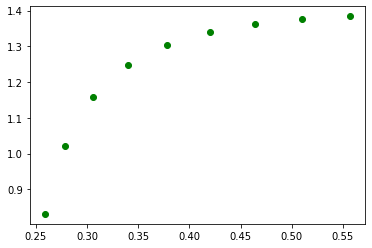

In [ ]:
#Proporción constante durante todo el período

prop_MSR_GMV = [10,20,30,40,50,60,70,80,90]
prop_GMV = [90,80,70,60,50,40,30,20,10]

list_of_portfolios_2 = {'MSR': dict(cleaned_MS_weights), 'GMV':cleaned_weights_gmv}

df_portfolio_columns_2 = []
precios_simulados_2 = precios_simulados

for i in prop_MSR_GMV:
  precios_simulados_2[f'weights_{i}_MSR'] = precios_simulados_2['Activo'].map(list_of_portfolios_2['MSR'])*i/100
  precios_simulados_2[f'weights_{100-i}_GMV'] = precios_simulados_2['Activo'].map(list_of_portfolios_2['GMV'])*(100-i)/100
  precios_simulados_2[f'weighted_sim_returns_{i}_MSR'] = precios_simulados['Retornos % Sim']*precios_simulados[f'weights_{i}_MSR']
  precios_simulados_2[f'weighted_sim_returns_{100-i}_GMV'] = precios_simulados['Retornos % Sim']*precios_simulados[f'weights_{100-i}_GMV']
  precios_simulados_2[f'Portf_{i}_MSR_{100-i}_GMV'] = precios_simulados_2[f'weighted_sim_returns_{i}_MSR'] + precios_simulados_2[f'weighted_sim_returns_{100-i}_GMV']

  df_portfolio_columns_2.append(f'Portf_{i}_MSR_{100-i}_GMV')


portfolio_sim_returns_2 = []
for z in range(len_simulation): #Selecciono simulación
  precios_simulados_selected = precios_simulados[precios_simulados_2['Sim']==z]
  for i in df_portfolio_columns_2: #Para cada simulación, simulo retorno promedio del portfolio
    retorno_medio = precios_simulados_selected[i].sum()
    retorno_medio = float(retorno_medio)
    portfolio_sim_returns_2.append([z, i , retorno_medio])

portfolio_sim_returns_2 = pd.DataFrame(portfolio_sim_returns_2)
portfolio_sim_returns_2.columns = ['Sim','Portfolio','Ret']

stats = []
for i in df_portfolio_columns_2:
  selected_portfolio = portfolio_sim_returns_2[portfolio_sim_returns_2['Portfolio']==i]
  mean = selected_portfolio['Ret'].mean()

  vol = []
  for j in range(len(selected_portfolio)):
    vol_2 = (selected_portfolio.iloc[[j]]['Ret']-mean)**2
    vol_2 = float(vol_2)
    vol.append(vol_2)
  vol = sum(vol)
  vol = np.sqrt(vol/len(selected_portfolio))
  apendeo = [i, mean*100, vol*100]
  stats.append(apendeo)

stats = pd.DataFrame(stats)
stats.columns = ['Portfolio', 'Return', 'Vol']
stats['Sharpe'] = (stats['Return'] - risk_free*100)/stats['Vol']

print(stats)

plt.scatter(stats['Vol'], stats['Sharpe'], c="g")
plt.show()

{'Ponderacion8': {0: 0.6, 1: 0.6, 2: 0.6, 3: 0.6, 4: 0.6, 5: 0.6, 6: 0.6, 7: 0.6, 8: 0.4, 9: 0.4, 10: 0.4, 11: 0.4, 12: 0.4, 13: 0.4, 14: 0.4, 15: 0.4, 16: 0.4, 17: 0.4, 18: 0.4, 19: 0.4, 20: 0.4, 21: 0.4, 22: 0.4, 23: 0.4, 24: 0.4, 25: 0.4, 26: 0.4, 27: 0.4, 28: 0.4, 29: 0.4}}
       Portfolio    Return       Vol    Sharpe
0   Pond8_return  0.459337  0.282210  1.042969
1  Pond16_return  0.499978  0.303706  1.102969
2  Pond24_return  0.587033  0.357438  1.180714


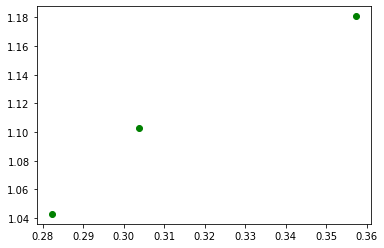

In [ ]:
#Proporción que cambia a los 8, 16 y 24 dias

fechas_corte = [8,16,24]

list_of_portfolios_3_8_22 = {'MSR': dict(cleaned_MS_weights), 'GMV':cleaned_weights_gmv}

ponderadores_a = np.repeat(0.6,8)
ponderadores_b = np.repeat(0.4,22)
ponderadores_1 = np.concatenate([ponderadores_a, ponderadores_b])
ponderadores_1=pd.DataFrame(ponderadores_1, columns = ['Ponderacion8'])
ponderadores_1=ponderadores_1.to_dict()
print(ponderadores_1)

ponderadores_c = np.repeat(0.6,16)
ponderadores_d = np.repeat(0.4,14)
ponderadores_2 = np.concatenate([ponderadores_c, ponderadores_d])
ponderadores_2 = pd.DataFrame(ponderadores_2, columns = ['Ponderacion16'])
ponderadores_2 = ponderadores_2.to_dict()

ponderadores_e = np.repeat(0.6,24)
ponderadores_f = np.repeat(0.4,6)
ponderadores_3 = np.concatenate([ponderadores_e, ponderadores_f])
ponderadores_3 = pd.DataFrame(ponderadores_3, columns = ['Ponderacion24'])
ponderadores_3 = ponderadores_3.to_dict()

precios_simulados_3 = precios_simulados

precios_simulados_3['Pond8_MSR'] = np.zeros(len(precios_simulados_3))
precios_simulados_3['Pond8_MSR'] = precios_simulados_3['Fecha'].map(ponderadores_1['Ponderacion8'])
precios_simulados_3['Pond8_GMV'] = np.zeros(len(precios_simulados_3))
precios_simulados_3['Pond8_GMV'] = 1 - precios_simulados_3['Pond8_MSR']
precios_simulados_3['Pond8_return'] = np.zeros(len(precios_simulados_3))
precios_simulados_3['Pond8_return'] = precios_simulados_3['Pond8_MSR']* precios_simulados_3['weights_Max Sharpe']* precios_simulados_3['Retornos % Sim']
+ precios_simulados_3['Pond8_GMV']* precios_simulados_3['weights_GMV']* precios_simulados_3['Retornos % Sim']


precios_simulados_3['Pond16_MSR'] = np.zeros(len(precios_simulados_3))
precios_simulados_3['Pond16_MSR'] = precios_simulados_3['Fecha'].map(ponderadores_2['Ponderacion16'])
precios_simulados_3['Pond16_GMV'] = np.zeros(len(precios_simulados_3))
precios_simulados_3['Pond16_GMV'] = 1 - precios_simulados_3['Pond16_MSR']
precios_simulados_3['Pond16_return'] = np.zeros(len(precios_simulados_3))
precios_simulados_3['Pond16_return'] = precios_simulados_3['Pond16_MSR']* precios_simulados_3['weights_Max Sharpe']* precios_simulados_3['Retornos % Sim']
+ precios_simulados_3['Pond16_GMV']* precios_simulados_3['weights_GMV']* precios_simulados_3['Retornos % Sim']

precios_simulados_3['Pond24_MSR'] = np.zeros(len(precios_simulados_3))
precios_simulados_3['Pond24_MSR'] = precios_simulados_3['Fecha'].map(ponderadores_3['Ponderacion24'])
precios_simulados_3['Pond24_GMV'] = np.zeros(len(precios_simulados_3))
precios_simulados_3['Pond24_GMV'] = 1 - precios_simulados_3['Pond24_MSR']
precios_simulados_3['Pond24_return'] = np.zeros(len(precios_simulados_3))
precios_simulados_3['Pond24_return'] = precios_simulados_3['Pond24_MSR']* precios_simulados_3['weights_Max Sharpe']* precios_simulados_3['Retornos % Sim']
+ precios_simulados_3['Pond24_GMV']* precios_simulados_3['weights_GMV']* precios_simulados_3['Retornos % Sim']


df_portfolio_columns_3 = ['Pond8_return','Pond16_return','Pond24_return']

portfolio_sim_returns_3 = []

for z in range(len_simulation): #Selecciono simulación
   precios_simulados_3_selected = precios_simulados_3[precios_simulados_3['Sim']==z]
   for i in df_portfolio_columns_3: #Para cada simulación, simulo retorno promedio del portfolio
     retorno_medio = precios_simulados_3_selected[i].sum()
     retorno_medio = float(retorno_medio)
     portfolio_sim_returns_3.append([z, i , retorno_medio])

portfolio_sim_returns_3 = pd.DataFrame(portfolio_sim_returns_3)
portfolio_sim_returns_3.columns = ['Sim','Portfolio','Ret']

stats = []
for i in df_portfolio_columns_3:
  selected_portfolio = portfolio_sim_returns_3[portfolio_sim_returns_3['Portfolio']==i]
  mean = selected_portfolio['Ret'].mean()

  vol = []
  for j in range(len(selected_portfolio)):
    vol_2 = (selected_portfolio.iloc[[j]]['Ret']-mean)**2
    vol_2 = float(vol_2)
    vol.append(vol_2)
  vol = sum(vol)
  vol = np.sqrt(vol/len(selected_portfolio))
  apendeo = [i, mean*100, vol*100]
  stats.append(apendeo)

stats = pd.DataFrame(stats)
stats.columns = ['Portfolio', 'Return', 'Vol']
stats['Sharpe'] = (stats['Return'] - risk_free*100)/stats['Vol']

print(stats)

plt.scatter(stats['Vol'], stats['Sharpe'], c="g")
plt.show()

Se observa que:

1. Para una estrategia *fixed* donde para los 30 días se mantiene una misma proporción de cartera para MSR y GMV el retorno mensual se ubica dentro del [0.46% - 0.58%] con un Sharpe Ratio de ~1.06

2. Para una estrategia *con switch temporal* los retornos mensuales se ubican entre [0.46% - 0.49%] con Sharpe Ratios considerablemente más bajos.

En esta pequeña muestra no pareciera tener mucho sentido plantear un esquema con cortes temporales

## Notas y apéndices

*1 | Explicación de por qué usamos una descomposición de Cholesky para generar el análisis de montecarlo respetando la correlación entre activos https://assetpricingforbeginners.files.wordpress.com/2017/03/cholesky-decomposition.pdf
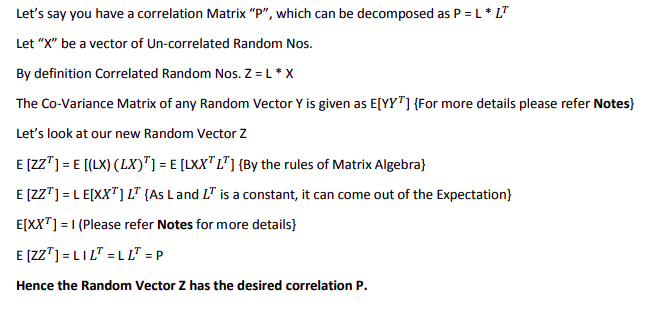